# Inference Guide


## Overview

We construct a promptable [ImageDecoder](../tokenize_anything/modeling/image_decoder.py) by adding a semantic token to each mask token. The semantic token is pre-trained to align EVACLIP-5B on SA-1B masks in a concept space merged from common datasets, thus it can be used for classification on a dataset-specific concept vocabulary. The semantic token is also used to prompt a [TextDecoder](../tokenize_anything/modeling/text_decoder.py) fine-tuning the 3.8M Visual Genome region captions. Therefore, **TAP** can conduct comprehensive understanding of arbitrary image regions.


## Setup

Necessary imports and helper functions for displaying points, boxes, and masks.

In [100]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

np.random.seed(1234)
inference_mode = torch.inference_mode()
inference_mode.__enter__()

def show_mask(mask, ax):
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    ax.imshow(mask.reshape(mask.shape[-2:] + (1,)) * color.reshape(1, 1, -1))


## Build

First, build the default ``TAP-L`` model.


In [101]:
import sys
sys.path.append("..")
from tokenize_anything import model_registry

model_type = "tap_vit_l"
checkpoint = "../models/tap_vit_l_v1_1.pkl"
model = model_registry[model_type](checkpoint=checkpoint)


To predict concepts and generate captions, setup [ConceptTokenizer](../tokenize_anything/modeling/concept_tokenizer.py) and [TextDecoder](../tokenize_anything/modeling/text_decoder.py).

In [102]:
concept_weights = "../concepts/merged_2560.pkl"
model.concept_projector.reset_weights(concept_weights)
model.text_decoder.reset_cache(max_batch_size=8)


## Preprocessing

Next, load and show the ``fairytale`` image.

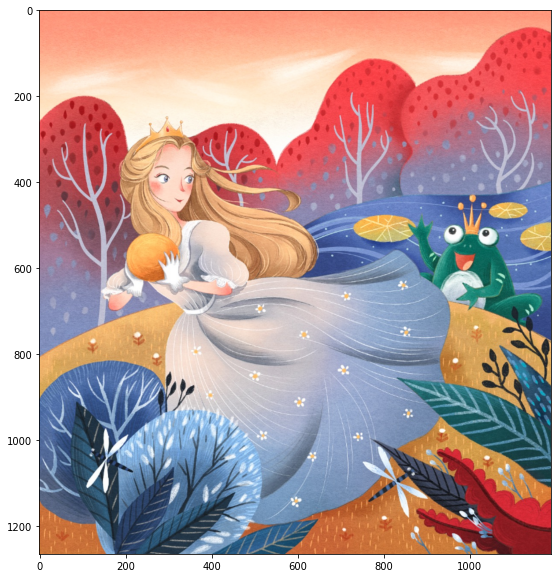

In [103]:
img = cv2.imread("images/fairytale.jpg")
vis_img = img.copy()[:, :, ::-1]
plt.figure(figsize=(10, 10))
plt.imshow(vis_img)
plt.show()


Resize image to match the maximal side length ``1024``.

In [104]:
from tokenize_anything.utils.image import im_rescale

img_list, img_scales = im_rescale(img, scales=[1024], max_size=1024)
input_size, original_size = img_list[0].shape, img.shape[:2]
print(input_size, "<-", original_size, "*", img_scales[0])


(1024, 964, 3) <- (1264, 1190) * (0.810126582278481, 0.810126582278481)


## Visual Encoding

Stack and pad image into a batch tensor of size ``(1, 1024, 1024, 3)`` to compute ``img_embeds``. 

In [105]:
from tokenize_anything.utils.image import im_vstack

img_batch = im_vstack(img_list, fill_value=model.pixel_mean_value, size=(1024, 1024))
inputs = model.get_inputs({"img": img_batch})
inputs.update(model.get_features(inputs))


## Visual Prompt Decoding: Point

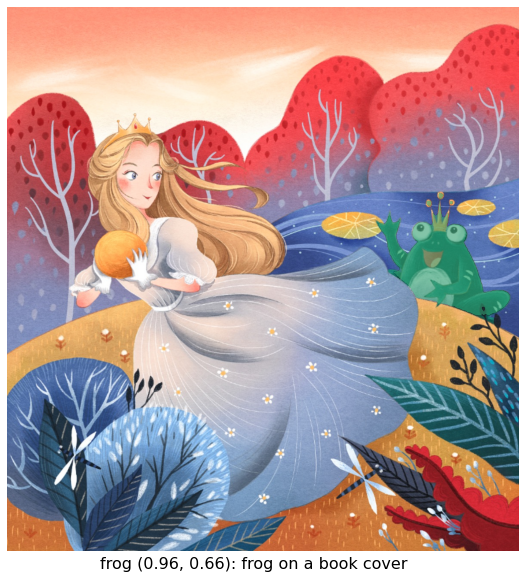

In [106]:
inputs["points"] = np.array([[[1050, 605, 1], [0, 0, 4]]], "float32")
inputs["points"][:, :, :2] *= np.array(img_scales, "float32")

# Decode outputs for the point prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 0] -= 1000.0  # Penalize the score of boundary boxes.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


## Visual Prompt Decoding: Box

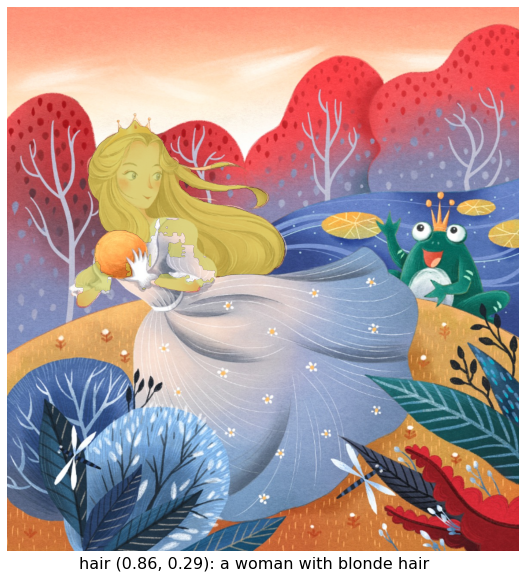

In [107]:
inputs["points"] = np.array([[[163, 237, 2], [682, 722, 3]]], "float32")
inputs["points"][:, :, :2] *= np.array(img_scales, "float32")

# Decode outputs for the box prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 1:] -= 1000.0  # Penalize the score of loose points.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()


## Visual Prompt Decoding: Sketch

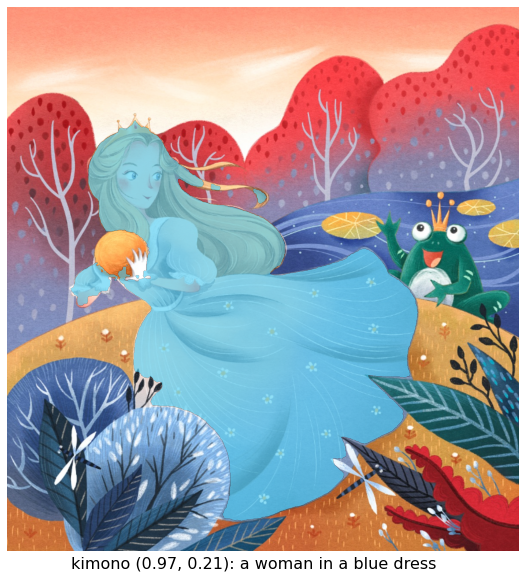

In [108]:
inputs["points"] = np.array([[
    [255, 337, 1], [295, 435, 1], [411, 598, 1], [415, 782, 1],
    [494, 937, 1], [702, 1090, 1], [812, 906, 1], [849, 748, 1], 
    [783, 627, 1], [0, 0, 4],
]], "float32")
inputs["points"][:, :, :2] *= np.array(img_scales, "float32")

# Decode outputs for the sketch prompt.
outputs = model.get_outputs(inputs)

# Select final mask.
iou_score, mask_pred = outputs["iou_pred"], outputs["mask_pred"]
iou_score[:, 0] -= 1000.0  # Penalize the score of boundary boxes.
mask_index = torch.arange(iou_score.shape[0]), iou_score.argmax(1)

# Upscale masks to the original image resolution.
iou_scores, masks = iou_score[mask_index], mask_pred[mask_index]
masks = model.upscale_masks(masks[:, None], img_batch.shape[1:-1])
masks = masks[..., : input_size[0], : input_size[1]]
masks = model.upscale_masks(masks, original_size).gt(0).cpu().numpy()

# Predict concepts and generate captions.
sem_tokens, sem_embeds = outputs["sem_tokens"], outputs["sem_embeds"]
concepts, scores = model.predict_concept(sem_embeds[mask_index])
captions = model.generate_text(sem_tokens[mask_index])

# Display comprehensive visual understanding.
text_contents = [v.flatten()[0] for v in (concepts, iou_scores, scores, captions)]
vis_text = "{} ({:.2f}, {:.2f}): {}".format(*text_contents)
plt.figure(figsize=(10,10))
plt.imshow(vis_img)
plt.figtext(0.5, 0.1, vis_text, fontsize=16, ha="center")
show_mask(masks, plt.gca())
plt.axis('off')
plt.show()
